# Introduction:
For constructing a robust music genre classifier, it is necessary to extract features that allow direct access to the relevant genre-specific information. The feature extraction process is applied to the GTZAN dataset in order to discriminate five music genres: 'Classical', 'Pop', 'Reggae', 'Rock', 'Jazz'. Each song
in the database was stored as a 22050 [Hz], 16bits, and mono audio file.

In [73]:
import os
import warnings
import librosa 
import librosa.display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import kurtosis
from scipy.stats import skew

from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from random import randint

# Feature Extraction Process:
Different kind of *low-level* and *high level* audio features are computed. They are categorized into rhythmic, spectral and tonal. They are decomposed into low-level and high-level according to the frame size: low-level features are extracted from a short window (1024 samples, 44.45 [ms] of duration) while high-level features are extracted from longer windows to gain a better frequency resolution (4096 samples, 186 [ms]), the first with 50% of overlap between successive windows, the second with 75%.


1.   **Rhythmic Features**:   

>* Tempo;

2.   **Spectral Features**:

>* Spectral Centroid;
* Spectral Rolloff (85%);
* Spectral Rolloff (95%);
* Spectral Flux;
* RMS Energy;
* Zero-Crossing Rate;
* Spectral Bandwidth;
* Spectral Flatness;
* Spectral Contrast;
* MFCCs;

3. **Tonal Features** (Harmonic):

>* Chromagram;
*Tonal Centroid;
*HCDF (Harmonic Change Detection Function);

The different frame-based features are computed and then integrated over the all audio extract duration by means of the different **statistical moments** like *maximum* value, *minimum* value, *mean*, *standard deviation*, *skewness* and *kurtosis*.
Rhythmic and Tonal features are high-level features and need the longer analysis window to capture their correct behaviour.

In [74]:
def get_features(y, sr):
    # Low-level features Analysis parameters
    n_fft_ll=1024
    hop_length_ll=512

    # High-level features Analysis parameters
    n_fft_hl=4096
    hop_length_hl=1024

    # Low-level features to be computed
    features = {
        'centroid': None,
        'rolloff85': None,
        'rolloff95': None,
        'flux': None,
        'rmse': None,
        'zcr': None,
        'bandwidth': None,
        'flatness': None
    }

    # Computing Spectral Low-level features using Librosa library functions:
    # Spectral Centroid:
    features['centroid'] = librosa.feature.spectral_centroid(y=y,
                                                             sr=sr, 
                                                             n_fft=n_fft_ll, 
                                                             hop_length=hop_length_ll)
    # Spectral Rolloff (85%)
    features['rolloff85'] = librosa.feature.spectral_rolloff(y=y, 
                                                             sr=sr, 
                                                             n_fft=n_fft_ll, 
                                                             hop_length=hop_length_ll, 
                                                             roll_percent=0.85)
    # Spectral Rolloff (95%)
    features['rolloff95'] = librosa.feature.spectral_rolloff(y=y, 
                                                             sr=sr, 
                                                             n_fft=n_fft_ll, 
                                                             hop_length=hop_length_ll, 
                                                             roll_percent=0.95)
    # Spectral Flux
    features['flux'] = librosa.onset.onset_strength(y=y, 
                                                    sr=sr)
    # Root Mean Square Energy
    features['rmse'] = librosa.feature.rms(y=y, 
                                           frame_length=n_fft_ll, 
                                           hop_length=hop_length_ll)
    # Zero-Crossing Rate
    features['zcr'] = librosa.feature.zero_crossing_rate(y=y, 
                                                         frame_length=n_fft_ll, 
                                                         hop_length=hop_length_ll)
    # Spectral Bandwidth
    features['bandwidth'] = librosa.feature.spectral_bandwidth(y=y, 
                                                               sr=sr, 
                                                               n_fft=n_fft_ll, 
                                                               hop_length=hop_length_ll)
    # Spectral Flatness
    features['flatness'] = librosa.feature.spectral_flatness(y=y,
                                                             n_fft=n_fft_ll,
                                                             hop_length=hop_length_ll)
    # Spectral Contrast
    contrast = librosa.feature.spectral_contrast(y=y, 
                                                 sr=sr,
                                                 n_fft=n_fft_ll,
                                                 hop_length=hop_length_ll)
    for idx, v_contrast in enumerate(contrast):
        features['contrast_{}'.format(idx)] = contrast
    
    # Mel-Frequency Cepstral Coefficients (MFCCs)
    mfcc = librosa.feature.mfcc(y=y, 
                                n_fft=n_fft_ll,
                                hop_length=hop_length_ll, 
                                n_mfcc=13)
    for idx, v_mfcc in enumerate(mfcc):
        features['mfcc_{}'.format(idx)] = v_mfcc
    
    # Computing the Tonal High-Level features using Librosa library functions:
    # Chromagram
    chroma = librosa.feature.chroma_stft(y=y, 
                                         sr=sr, 
                                         n_fft=n_fft_hl,
                                         hop_length=hop_length_hl)
    for idx, v_chroma in enumerate(chroma):
        features['chroma_{}'.format(idx)] = v_chroma

    # Tonal Centroid
    tonal_centroid = librosa.feature.tonnetz(y=librosa.effects.harmonic(y=y), sr=sr)
    for idx, v_tonal in enumerate(tonal_centroid):
        features['tonnetz{}'.format(idx)] = v_tonal

    # Harmonic Changes Detection Function
    features['hcdf'] = librosa.onset.onset_strength(sr=sr, S=tonal_centroid) 
    
    # This inner function extracts the statistical moments from the vectors:
    def get_moments(descriptors):
        result = {}
        for k, v in descriptors.items():
            result['{}_max'.format(k)] = np.max(v)
            result['{}_min'.format(k)] = np.min(v)
            result['{}_mean'.format(k)] = np.mean(v)
            result['{}_std'.format(k)] = np.std(v)
            result['{}_kurtosis'.format(k)] = kurtosis(v, axis=None)
            result['{}_skew'.format(k)] = skew(v, axis=None)
        return result
    
    # Computing the statistical moments for each feature:
    stat_features = get_moments(features)

    # Computing the Rhythmic High-Level features using Librosa library functions:
    stat_features['tempo'] = librosa.beat.tempo(y, sr=sr)[0]

    return stat_features

# Loading samples:
 The following function parses the folder structure of the dataset in order to load and compute the features of each audio sample: the 'genres' folder contains a folder for each music genre that needs to be classified. 


In [75]:
def read_process_songs(src_dir):
    # Numerical mapping for each genre label
    genres = {
      'classical': 0,
      'pop': 1,
      'reggae': 2,
      'rock': 3,
      'jazz': 4,
    }

    # Empty array to store every computed feature vector for each sample
    feature_space = []

    for x, _ in genres.items():
      if x == 'rock':
        folder = src_dir + '/' + x
        for root, subdirs, files in os.walk(folder):
          for file in sorted(files[0:50]):
           # Read the audio files with the Librosa load function
           file_name = folder + '/' + file
           signal, sr = librosa.load(file_name)
           print("Reading file: {}".format(file_name))
           # Extract the features
           features = get_features(signal[0:sr*3+1], sr)
           # Label the feature vector
           features['genre'] = genres[x]
           feature_space.append(features)
           
        folder = src_dir + '/' + 'metal'
        for root, subdirs, files in os.walk(folder):
          for file in sorted(files[0:50]):
           # Read the audio files with the Librosa load function
           file_name = folder + '/' + file
           signal, sr = librosa.load(file_name)
           print("Reading file: {}".format(file_name))
           # Extract the features
           #start = randint(0,29*fs-1)
           start = 0
           features = get_features(signal[start:start+sr*3+1], sr)
           # Label the feature vector
           features['genre'] = genres[x]
           feature_space.append(features)
           
      else:
       
       folder = src_dir + '/' + x
       for root, subdirs, files in os.walk(folder):
         for file in sorted(files):
          # Read the audio files with the Librosa load function
          file_name = folder + '/' + file
          signal, sr = librosa.load(file_name)
          print("Reading file: {}".format(file_name))
          # Extract the features
          #start = randint(0,29*fs-1)
          start = 0
          features = get_features(signal[start:start+sr*3+1], sr)
          # Label the feature vector
          features['genre'] = genres[x]
          feature_space.append(features)
    return feature_space

# Features computation:
Extraction of the features for all audio samples and later conversion of the feature_space table object into a `DataFrame` object, which contains a row for each audio entry and a number of columns equal to the total number of features computed; everything is then exported into a .csv file to be used in the Classification step. In the console there is a plotting of a Deprecated use of `np.asscalar(a)` which is caused by the `Librosa` library itself (this is why the filtering of the warnings is used).

In [76]:
warnings.filterwarnings("ignore")
feature_space = read_process_songs('genres');

df_features = pd.DataFrame(feature_space)
df_features.to_csv('features.csv', index=False)

enres/classical/classical.00035.wav
Reading file: genres/classical/classical.00036.wav
Reading file: genres/classical/classical.00037.wav
Reading file: genres/classical/classical.00038.wav
Reading file: genres/classical/classical.00039.wav
Reading file: genres/classical/classical.00040.wav
Reading file: genres/classical/classical.00041.wav
Reading file: genres/classical/classical.00042.wav
Reading file: genres/classical/classical.00043.wav
Reading file: genres/classical/classical.00044.wav
Reading file: genres/classical/classical.00045.wav
Reading file: genres/classical/classical.00046.wav
Reading file: genres/classical/classical.00047.wav
Reading file: genres/classical/classical.00048.wav
Reading file: genres/classical/classical.00049.wav
Reading file: genres/classical/classical.00050.wav
Reading file: genres/classical/classical.00051.wav
Reading file: genres/classical/classical.00052.wav
Reading file: genres/classical/classical.00053.wav
Reading file: genres/classical/classical.00054

# Feature Analysis and Class Separability:
Considering a single feature at the time, we want to evaluate its discrimination power among classes. In order to do so, the *Fisher Discriminant Ratio* Definition is applied to each single feature for each possible couple of classes that need to be discriminated.
>$ FDR = \frac{(\mu_i - \mu_j)^2}{\sigma_i^2 + \sigma_j^2}$ 

In [77]:
# Definition of Fisher Discriminant Ratio function
def compute_FDR(genre_idx1, genre_idx2, dimension):
    # Consider all the samples for each specific genre
    samples_genre1 = df_features[100*genre_idx1 : 100*(genre_idx1+1)]
    samples_genre2 = df_features[100*genre_idx2 : 100*(genre_idx2+1)]

    # Compute the centroid and the variance of the given feature dimension
    centroid1 = np.mean(samples_genre1.loc[:, dimension], axis=None)
    centroid2 = np.mean(samples_genre2.loc[:, dimension], axis=None)
    variance1 =  np.var(samples_genre1.loc[:, dimension], axis=None)
    variance2 = np.var(samples_genre2.loc[:, dimension], axis=None)

    # Applying the Definition
    numerator = (centroid1 - centroid2)**2
    denominator = variance1 + variance2
    if denominator != 0 :
        return numerator/denominator
    else :
        return 0
   

The following cell of code computes the FDR for each possible couple of genres and all possible feature dimension.

In [78]:
feature_names = list(feature_space[0].keys())
# Removing the labeling
feature_names.remove('genre')

# Mapping of genres with their numerical identificator
genres = {
       'classical': 0,
      'pop': 1,
      'reggae': 2,
      'rock': 3,
      'jazz': 4
      }

# Computing the one-vs-one binary classes from the multiclass problem
genre_combinations = list(itertools.combinations(genres.keys(),2))

# This function extracts from a dictionary the field 'FDR'
def get_value(e):
    return e['FDR']

# The matrix will contain all the FDR values
FDR_matrix = []
# The matrix will contain all the features re-ordered starting from the higher FDR
FDR_feature_matrix = []

for gen1,gen2 in genre_combinations:
    i1 = genres[gen1]
    i2 = genres[gen2]
    row = []
    for feature in feature_names:
        FDR = compute_FDR(i1, i2, feature)
        row.append({'FDR':FDR,'feature':feature})
    row.sort(reverse=True,key=get_value)
    FDR_matrix.append(row)
    FDR_feature_matrix.append([el['feature'] for el in row])

 

In [79]:
print("classical vs pop:    ", FDR_feature_matrix[0]) 
print("classical vs reggae: ", FDR_feature_matrix[1])
print("classical vs rock:   ", FDR_feature_matrix[2])
print("pop vs reggae:   ", FDR_feature_matrix[3])
print("pop vs rock:     ", FDR_feature_matrix[4])
print("reggae vs rock:  ", FDR_feature_matrix[5])

sis', 'chroma_8_min', 'tonnetz0_skew', 'mfcc_11_kurtosis', 'mfcc_7_min', 'chroma_2_min', 'tonnetz2_kurtosis', 'chroma_10_min', 'mfcc_7_kurtosis', 'rmse_skew', 'mfcc_1_kurtosis', 'tonnetz4_skew', 'mfcc_6_skew', 'tonnetz5_max', 'chroma_11_min', 'rolloff85_skew', 'chroma_4_min', 'mfcc_11_skew', 'mfcc_9_min', 'tonnetz2_mean', 'mfcc_5_min', 'tonnetz5_skew', 'mfcc_0_kurtosis', 'mfcc_4_kurtosis', 'mfcc_5_skew', 'tonnetz3_mean', 'flatness_min', 'rolloff95_min', 'mfcc_10_min', 'chroma_3_min', 'tonnetz3_kurtosis', 'hcdf_kurtosis', 'mfcc_9_kurtosis', 'chroma_7_min', 'chroma_9_min', 'flatness_skew', 'mfcc_12_min', 'chroma_0_min', 'contrast_0_std', 'contrast_1_std', 'contrast_2_std', 'contrast_3_std', 'contrast_4_std', 'contrast_5_std', 'contrast_6_std', 'hcdf_skew', 'flux_kurtosis', 'chroma_1_min', 'mfcc_9_skew', 'mfcc_0_skew', 'chroma_5_min', 'rmse_kurtosis', 'mfcc_12_std', 'tonnetz2_skew', 'tonnetz2_min', 'mfcc_10_kurtosis', 'mfcc_6_kurtosis', 'mfcc_8_kurtosis', 'mfcc_2_kurtosis', 'mfcc_8_min', 

# Features Visualization:
Through *dimensionality reduction* tecniques it is possible to limit the number of random variables (features) under consideration, obtaining a set of principal variables that can be visualized in a 2-dimensional feature space. The **LDA algorithm** (Linear Discriminant Analysis) can be used for this purpose, because it is able to find out, through a process of optimization of the Fisher Discriminant Ratio, the dimension that accounts for most of the variance between classes, and to project the data along it.

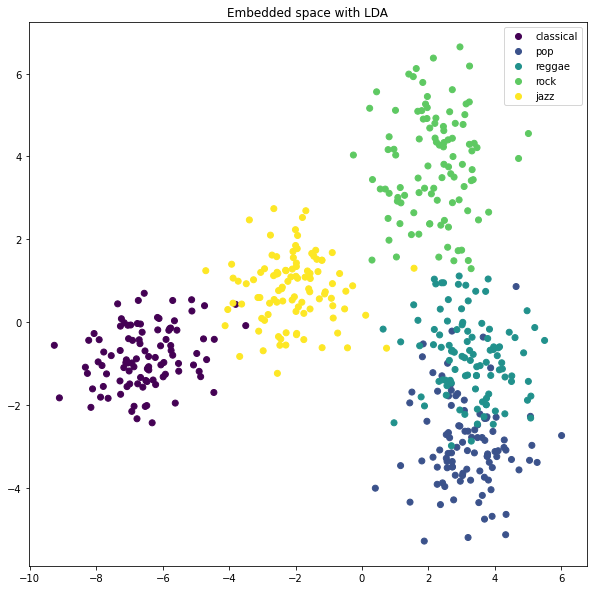

In [80]:
scale = StandardScaler()

X = df_features.drop(['genre'], axis=1).values
y = df_features['genre'].values

x_scaled = scale.fit_transform(X)

lda = LDA(n_components=2)
x_lda = lda.fit_transform(x_scaled, y)

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_lda[:,0], x_lda[:,1], c=y)
plt.legend(handles=scatter.legend_elements()[0], labels=genres)
plt.title("Embedded space with LDA")
plt.show()

# Music Genre Classification:
Using the features extracted from the audio segments contained in the GTZAN dataset, we build up the model for classification. The Classification is only limited to the classes 'Classical', 'Pop', 'Reggae', 'Rock', 'Jazz'.

In [81]:
#from google.colab import files

import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import lightgbm as lgbm

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Uploading the features from csv file:
The data loaded from the csv file are represented in the structured way imposed by the Dataframe representation.

In [82]:
features = pd.read_csv('features.csv')

# Dropping the column representing the labels
X = features.drop(['genre'], axis=1).values
# Definition of the vector of labels
y = features['genre'].values

# Splitting the data into Training Set and Test Set:
This operation builds the sets `X_train` and `y_train` which are the training set of features and their corresponding set of labels, and the sets `X_test` and `y_test` which are the testing set of features. '`random_state`' is set to a fixed value in order to make the results replicable at every new execution.

In [83]:
# The test_size will be by default the 0.25 of the dataset, while
# the labels of the corresponding sets are built over y
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=14)

# SVM: Feature Processing, Feature Selection and Classification Model
The following operations define the parameters and the pipeline to use for Support Vector Machine classification:

The parameters set are the following:

*   **'`cls__C`'**: these parameters specify different regularization factors to apply to the model to avoid overfitting.
*   **'`cls__kernel`'**: these parameters specify different kernels (Radial Basis Function kernel, Linear kernel, Sigmoidal kernel) to map the features into different feature spaces to try to improve the classification.

The pipeline defines a composite estimator applying the following transformations:


*   **'`scale`'**: standardizes features by removing the mean and scaling to unit variance.
*  **'`var_tresh`'**: it removes all features whose variance doesn’t meet some threshold.
*  **'`feature_selection`'**: in the specific, the function SelectFromModel is a meta-transformer that works after fitting and removes the features considered unimportant.
*  **'`cls`'**: Support Vector Classification is the tecnique used to perform the classification.

In [84]:
params = {
    'cls__C': [0.5, 1, 2, 5],
    'cls__kernel': ['rbf', 'linear', 'sigmoid'],
}

pipe_svm = Pipeline([
    ('scale', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', SVC())
])

# Model Training:
The `GridSearchCV` exhaustively considers all parameter combinations, and when “fitting” it on a dataset all the possible combinations of parameter values are evaluated and the best combination with respect to the scoring parameter specified ('`accuracy`' in this case) is retained.

In [85]:
grid_svm = GridSearchCV(pipe_svm, params, scoring='accuracy', n_jobs=6, cv=5)
# Performing the model training
grid_svm.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', SVC())]),
             n_jobs=6,
             param_grid={'cls__C': [0.5, 1, 2, 5],
                         'cls__kernel': ['rbf', 'linear', 'sigmoid']},
             scoring='accuracy')

# Model Testing and Accuracy Evaluation:
The model is evaluated on the test set extracted at the beginning from the feature dataset in performing class prediction on newly unseen data.
Accuracy scores achieved by the model both on Validation set (after the Cross Validation process) and Test set are plotted. More structured informations regarding hyper-parameters estimation and prediction performances are reported.

In [86]:
predictions = grid_svm.predict(X_test)

print("Score on training set (accuracy) = {:.4f}\n".format(grid_svm.score(X_train, y_train)))

print("Cross Validation scores (accuracy) for each set of parameters (95% confidence interval):")

means = grid_svm.cv_results_['mean_test_score']
stds = grid_svm.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, grid_svm.cv_results_['params']):
  print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

print("Best score on validation set (accuracy) = {:.4f}".format(grid_svm.best_score_))
print("Given the parameters:")
print("C = {}".format(grid_svm.best_params_['cls__C']))
print("Kernel = {}\n".format(grid_svm.best_params_['cls__kernel']))

print("Classification Report on Test Set:")
print(classification_report(y_test, predictions, target_names=['classical','pop','reggae','rock', 'jazz']))
print("Score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, predictions)))

Score on training set (accuracy) = 0.9653

Cross Validation scores (accuracy) for each set of parameters (95% confidence interval):
0.821 (+/-0.064) for {'cls__C': 0.5, 'cls__kernel': 'rbf'}
0.768 (+/-0.107) for {'cls__C': 0.5, 'cls__kernel': 'linear'}
0.779 (+/-0.078) for {'cls__C': 0.5, 'cls__kernel': 'sigmoid'}
0.840 (+/-0.048) for {'cls__C': 1, 'cls__kernel': 'rbf'}
0.768 (+/-0.107) for {'cls__C': 1, 'cls__kernel': 'linear'}
0.795 (+/-0.085) for {'cls__C': 1, 'cls__kernel': 'sigmoid'}
0.835 (+/-0.040) for {'cls__C': 2, 'cls__kernel': 'rbf'}
0.768 (+/-0.107) for {'cls__C': 2, 'cls__kernel': 'linear'}
0.784 (+/-0.088) for {'cls__C': 2, 'cls__kernel': 'sigmoid'}
0.835 (+/-0.064) for {'cls__C': 5, 'cls__kernel': 'rbf'}
0.768 (+/-0.107) for {'cls__C': 5, 'cls__kernel': 'linear'}
0.760 (+/-0.061) for {'cls__C': 5, 'cls__kernel': 'sigmoid'}

Best score on validation set (accuracy) = 0.8400
Given the parameters:
C = 1
Kernel = rbf

Classification Report on Test Set:
              precision

# Confusion Matrix:
Below the definition of the function to properly plot the confusion matrix and its evaluation on the model.

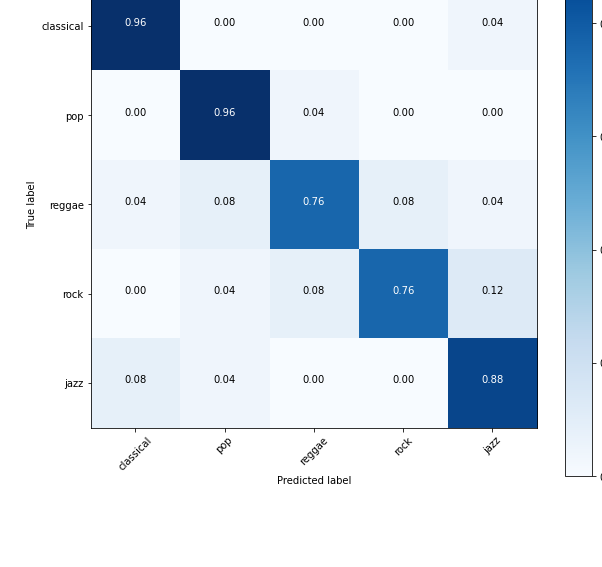

In [87]:
def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    
    # Normalization can be applied by setting normalize=True
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


# Computing the confusion matrix between predictions and real labels through the
# sklearn library function
cm = confusion_matrix(y_test, predictions)
classes = ['classical', 'pop', 'reggae', 'rock', 'jazz']

plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm, classes, normalize=True)

# Recording and Communication with Processing
The code below makes a recording of 1 second every second of music.
After the recording the code extracts the features on the recorded signal and predicts the genre. Finally the labelled genre is sent to processing via OSC messages.

In [90]:
#extract features from our recording

import sounddevice as sd 
import librosa
import scipy
from scipy.io.wavfile import write
import time 
from pythonosc import udp_client
import keyboard  


while True:
    if keyboard.is_pressed('s'):
        print('You Exited Recording Mode!')
        break 
    else: 
        generi = []
        duration = 1 # seconds
        fs=22050
        myrecording = sd.rec(int(duration * fs), samplerate=fs, channels=1)
        sd.wait()

        scipy.io.wavfile.write('bb.wav', 22050, myrecording)

        signal, sr = librosa.load('bb.wav')

        prova=get_features(signal, sr)

        feature_space_rec=[]
        feature_space_rec.append(prova)
        df_new_features = pd.DataFrame(feature_space_rec)
        df_new_features.to_csv('recording.csv', index=False)

        #Prediction
        features_rec = pd.read_csv('recording.csv')
        for i in range(10):
            predictions_rec = grid_svm.predict(features_rec)
            genre=classes[predictions_rec[0]]
            generi.append(genre)
           # print(generi)
            regN=generi.count('reggae')
            rocN=generi.count('rock')
            claN=generi.count('classical')
            jazN=generi.count('jazz')
            popN=generi.count('pop')
            generiN=[claN, popN, regN, rocN, jazN]
            if(max(generiN)>=5):
                indexgen = generiN.index(max(generiN))
               # print(indexgen)
               # print(str(regN)+" reggae num "+str(rocN)+" rock num "+ str(claN)+" classica num "+str(jazN) + "     jazz num "+ str(popN) + " pop num")
    


                #send message to processing 

                delay = 1 
                # OSC client -> Processing
                client = udp_client.SimpleUDPClient("127.0.0.1", 12000)
                bpm = features_rec.iloc[0,-1] 
                print(bpm)
                # send data to Processing
                client.send_message( "/genre", classes[indexgen]) 
                client.send_message("/bpm", bpm)
                # wait
                time.sleep(delay)


43.5546875
143.5546875
143.5546875
143.5546875
143.5546875
135.99917763157896
135.99917763157896
135.99917763157896
135.99917763157896
135.99917763157896
135.99917763157896
172.265625
172.265625
172.265625
172.265625
172.265625
172.265625
172.265625
172.265625
172.265625
172.265625
172.265625
172.265625
123.046875
123.046875
123.046875
123.046875
123.046875
123.046875
123.046875
123.046875
123.046875
123.046875
123.046875
123.046875
123.046875
123.046875
123.046875
123.046875
123.046875
123.046875
129.19921875
129.19921875
129.19921875
129.19921875
129.19921875
129.19921875
112.34714673913044
112.34714673913044
112.34714673913044
112.34714673913044
112.34714673913044
112.34714673913044
172.265625
172.265625
172.265625
172.265625
172.265625
172.265625
117.45383522727272
117.45383522727272
117.45383522727272
117.45383522727272
117.45383522727272
117.45383522727272
143.5546875
143.5546875
143.5546875
143.5546875
143.5546875
143.5546875
143.5546875
143.5546875
143.5546875
143.5546875
143.5